<a href="https://colab.research.google.com/github/RochitJain/ML_AI/blob/main/carlifornia_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
print(data)

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]]), 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]), 'frame': None, 'target_names': ['MedHouseVal'], 'feature_names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n-

In [27]:
X = pd.DataFrame(data.data,columns=data.feature_names)
y = pd.DataFrame(data.target)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [23]:
def clip_outliers(X, col, lower_q=0.01, upper_q=0.99):
    low = X[col].quantile(lower_q)
    high = X[col].quantile(upper_q)
    X[col] = np.clip(X[col], low, high)

cols_to_clip = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

for col in cols_to_clip:
    clip_outliers(X, col)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

models = {
    'Random': RandomForestRegressor(),
    'Linear': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'DecisionTree': DecisionTreeRegressor(),
    'XGBoost' : XGBRegressor()
}

for name,model in models.items():
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"{name}: CV Mean R2 = {score.mean():.4f}")

In [ ]:
# didnt do because took time, so used randomsearchCV for XGBoost
from sklearn.model_selection import GridSearchCV

random_forest_params = {
    'n_estimators': [100],
    'max_depth': [None,10],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor()

grid_cv = GridSearchCV(model,random_forest_params, cv=5, scoring='r2', n_jobs=1)
grid_cv.fit(X_train, y_train.values.ravel())

print("🔍 Best RF Params:", grid_cv.best_params_)
print("✅ RF Best R²:", grid_cv.best_score_)

In [37]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score

xgb_params = {
    'n_estimators': [100,200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.7,0.9, 1]
}

xgb = XGBRegressor()

# grid_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='r2', n_jobs=-1)
randomCV= RandomizedSearchCV(estimator=xgb,param_distributions=xgb_params, n_iter=20, cv=3, scoring='r2', n_jobs=-1, random_state=42, verbose=1)
randomCV.fit(X_train, y_train.values.ravel())

print("🔍 Best XGB Params:", randomCV.best_params_)
print("✅ XGB Best R²:", randomCV.best_score_)

final_model = randomCV.best_estimator_
y_pred = final_model.predict(X_test)

print('R2-score', r2_score(y_test,y_pred))
print("📉 RMSE:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔍 Best XGB Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}
✅ XGB Best R²: 0.8367656656687247
R2-score 0.8489392995834351
📉 RMSE: 0.20899957418441772


100%|===================| 4126/4128 [01:59<00:00]       

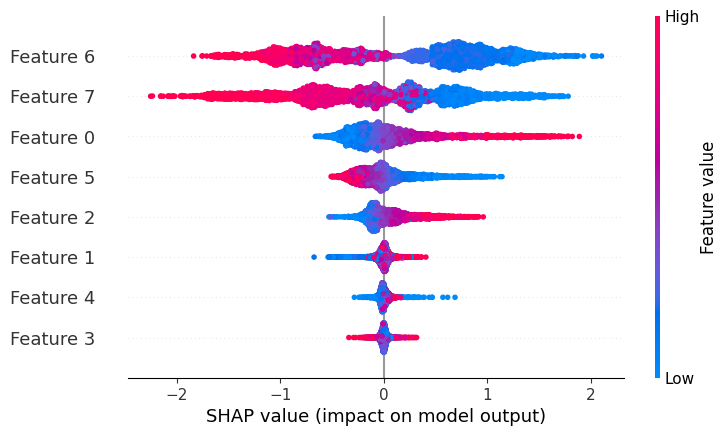

In [38]:
import shap
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)